In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from model import pipeline_manager

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ms-cmy/kaggle_datasets/main/titanic/train.csv')

In [3]:
def split_columns(X: pd.DataFrame) -> pd.DataFrame:
    column: str
    for column in X.columns:
        X[column] = X[column].str.split(',', n=1).str[-1].str.split('.', n=1).str[0].str.strip()
    return X

def new_feature(X: pd.DataFrame) -> pd.DataFrame:
    X['new_feature'] = X['SibSp'] + X['Parch'] + 1
    return X

In [4]:
preprocessor_1 = ColumnTransformer(transformers=[
    ('transformando_coluna', OneHotEncoder(sparse_output=False), ['Sex'])],
                                 remainder='drop')

pipeline_1 = Pipeline([('preprocessor', preprocessor_1),
                     ('classifier', LogisticRegression(fit_intercept=False))])

In [5]:
name_pipeline = Pipeline([
    ('extract_titles', FunctionTransformer(split_columns)),
    ('one_hot_encode', OneHotEncoder(min_frequency=20, handle_unknown='ignore', sparse_output=False)),
])

preprocessor_2 = ColumnTransformer(transformers=[
    ('transformando_coluna', OneHotEncoder(sparse_output=False), ['Sex']),
    ('one_hot_encode', name_pipeline, ['Name'])],
                                 remainder='drop')

pipeline_2 = Pipeline([('preprocessor', preprocessor_2),
                     ('classifier', LogisticRegression(fit_intercept=False))])

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class NewFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["new_feature"] = X['SibSp'] + X['Parch'] + 1
        return X[["new_feature"]]

    def get_feature_names_out(self):
        pass

name_pipeline_3 = Pipeline([
    ('extract_titles', FunctionTransformer(split_columns)),
    ('one_hot_encode', OneHotEncoder(min_frequency=20, handle_unknown='ignore', sparse_output=False))
])

preprocessor_3 = ColumnTransformer(transformers=[
    ('transformando_coluna', OneHotEncoder(sparse_output=False), ['Sex']),
    ('one_hot_encode', name_pipeline_3, ['Name']),
    ('new_feature', NewFeatureTransformer(), ['SibSp', 'Parch'])],
    remainder='drop')

pipeline_3 = Pipeline([
    ('preprocessor', preprocessor_3),
    ('classifier', LogisticRegression(fit_intercept=False))
])

In [7]:
pm = pipeline_manager.CategoricalModelPipe(x=df.drop(columns=['Survived']),
                                           y=df[['Survived']])

In [8]:
pm.add_pipe(pipe=(pipeline_1, pipeline_2, pipeline_3))

In [9]:
#pm.fit(test_size=0.33)
pm.fit(use_all_data=True)

In [10]:
preprocessor = pm.pipes[2]['pipe'].named_steps['preprocessor']

In [11]:
preprocessor.set_output(transform='pandas')

/home/nebula/python_envs/model_learning/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ColumnTransformer(transformers=[('transformando_coluna',
                                 OneHotEncoder(sparse_output=False), ['Sex']),
                                ('one_hot_encode',
                                 Pipeline(steps=[('extract_titles',
                                                  FunctionTransformer(func=<function split_columns at 0x7f60ba5e1620>)),
                                                 ('one_hot_encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=20,
                                                                sparse_output=False))]),
                                 ['Name']),
                                ('new_feature', NewFeatureTransformer(),
                                 ['SibSp', 'Parch'])])

In [12]:
preprocessor.transform(pm.x)

,transformando_coluna__Sex_female,transformando_coluna__Sex_male,one_hot_encode__Name_Master,one_hot_encode__Name_Miss,one_hot_encode__Name_Mr,one_hot_encode__Name_Mrs,one_hot_encode__Name_infrequent_sklearn,new_feature__new_feature
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
887,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
888,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4
889,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [13]:
plots = pipeline_manager.PlotCategoricalModel(pm)

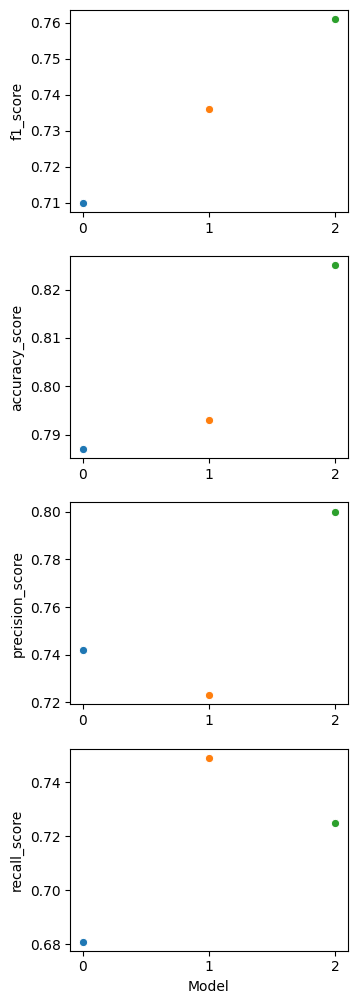

In [14]:
plots.plot_scores()

/home/nebula/python_envs/model_learning/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


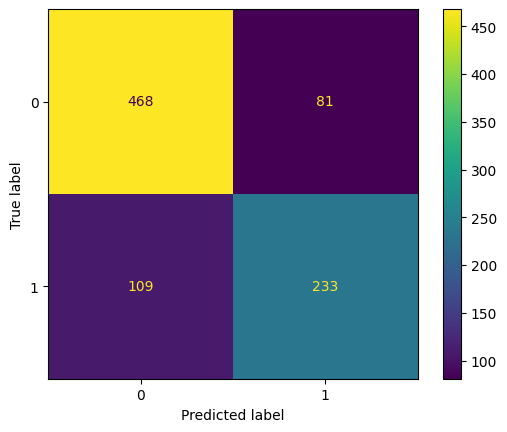

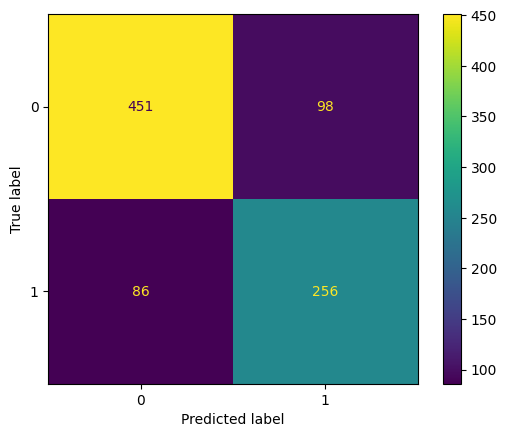

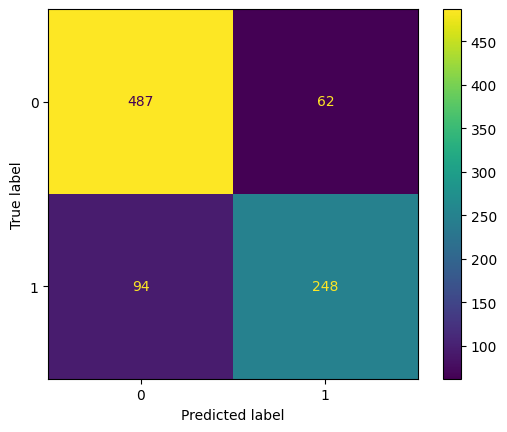

In [15]:
plots.plot_all_confusion_matrix()

In [16]:
df_test = pd.read_csv('https://raw.githubusercontent.com/ms-cmy/kaggle_datasets/main/titanic/test.csv')

In [17]:
result_pipeline = pm.result_pipe(2)

/home/nebula/python_envs/model_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
df_test['Survived'] = result_pipeline.predict(df_test)